In [ ]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import random
import xgboost as xgb
from scipy.stats import zscore
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split
from sklearn.model_selection import cross_validate
import pandas as pd
from pandas import read_csv
from scipy.stats import pearsonr
import math
from matplotlib import pyplot as plt
import statistics 
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix,recall_score,precision_score,f1_score,roc_auc_score
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from imblearn.combine import SMOTEENN
from collections import Counter
from sklearn.metrics import matthews_corrcoef

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
data=read_csv("/content/drive/MyDrive/project6thsem/cleveland.xls")
data=pd.DataFrame(data)
data=data.rename(columns={'target': 'presence'})
df=data
df

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,presence
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0


In [ ]:
attribute={}
for i in range(len(df.columns)):
  attribute[df.columns[i]]=i;

attribute

{'age': 0,
 'ca': 11,
 'chol': 4,
 'cp': 2,
 'exang': 8,
 'fbs': 5,
 'oldpeak': 9,
 'presence': 13,
 'restecg': 6,
 'sex': 1,
 'slope': 10,
 'thal': 12,
 'thalach': 7,
 'trestbps': 3}

In [ ]:
no_attribute={}
for i in attribute:
  no_attribute[attribute[i]]=i

no_attribute

{0: 'age',
 1: 'sex',
 2: 'cp',
 3: 'trestbps',
 4: 'chol',
 5: 'fbs',
 6: 'restecg',
 7: 'thalach',
 8: 'exang',
 9: 'oldpeak',
 10: 'slope',
 11: 'ca',
 12: 'thal',
 13: 'presence'}

In [ ]:
data=np.array(df)
data

array([[63.,  1.,  3., ...,  0.,  1.,  1.],
       [37.,  1.,  2., ...,  0.,  2.,  1.],
       [41.,  0.,  1., ...,  0.,  2.,  1.],
       ...,
       [68.,  1.,  0., ...,  2.,  3.,  0.],
       [57.,  1.,  0., ...,  1.,  3.,  0.],
       [57.,  0.,  1., ...,  1.,  2.,  0.]])

In [ ]:
class_count={}
for ind in df.index:
  if(df['presence'][ind] in class_count):
    class_count[df['presence'][ind]]+=1
  else:
    class_count[df['presence'][ind]]=1

class_count

{0: 138, 1: 165}

**1.Data Preprocessing**

In [ ]:
data_attr=[[] for i in range(14)]
for i in range(len(data)):
  for j in range(14):
    data_attr[j].append(data[i][j])

feature=[[] for i in range(13)]
for i in range(len(data)):
  for j in range(13):
    feature[j].append(data[i][j])

In [ ]:
feature_pos=[[] for i in range(13)]
for i in range(len(data)):
  for j in range(13):
    if(data[i][13]==1):
      feature_pos[j].append(data[i][j])
feature_neg=[[] for i in range(13)]
for i in range(len(data)):
  for j in range(13):
    if(data[i][13]==0):
      feature_neg[j].append(data[i][j])
print("Attribute","Mean(Present)","stddev(Present)","Mean(Absent)","stddev(Absent)")
for i in range(len(feature)):
  print(no_attribute[i],statistics.mean(feature_pos[i]),statistics.stdev(feature_pos[i]),statistics.mean(feature_neg[i]),statistics.stdev(feature_neg[i]))

Attribute Mean(Present) stddev(Present) Mean(Absent) stddev(Absent)
age 52.4969696969697 9.550650751946774 56.60144927536232 7.96208153750117
sex 0.5636363636363636 0.49744357555882157 0.8260869565217391 0.38041551386121214
cp 1.3757575757575757 0.9522215049717543 0.4782608695652174 0.9059204401375942
trestbps 129.3030303030303 16.169613266874865 134.3985507246377 18.72994396158135
chol 242.23030303030302 53.552871554538335 251.08695652173913 49.45461360407159
fbs 0.1393939393939394 0.34741150297891615 0.15942028985507245 0.36740114737023677
restecg 0.593939393939394 0.5048178818796776 0.4492753623188406 0.5413212245494148
thalach 158.46666666666667 19.174275619393168 139.1014492753623 22.598782298785906
exang 0.1393939393939394 0.34741150297891615 0.5507246376811594 0.49923245858990556
oldpeak 0.583030303030303 0.7806832719018301 1.5855072463768116 1.300339693105365
slope 1.593939393939394 0.5936346262434834 1.1666666666666667 0.5613244677999094
ca 0.36363636363636365 0.84889389358862

Data correlation by utilizing
Pearson’s Correlation Coefficient (PCC) can be used as a calculation tool to determine the relationship between attributes.
PCC varies from −1 to +1, with a positive and a negative value indicating a highly positive and highly negative
correlation between the variables, respectively, and a value
close to zero indicating a low correlation between them.

In [ ]:
# Pearson’s Correlation Coefficient (PPC)
PCC=[[0 for i in range(14)] for i in range(14)]
for i in range(14):
  for j in range(14):
    corr, _ = pearsonr(data_attr[i], data_attr[j])
    PCC[i][j]=corr

for i in range(14):
  print(no_attribute[i],end=" ")
print()
for i in range(14):
  
  for j in range(14):
    if(PCC[i][j]<0):
      print("%.2f"%PCC[i][j],end=" ")
    else:
      print("%.3f"%PCC[i][j],end=" ")
  print()


age sex cp trestbps chol fbs restecg thalach exang oldpeak slope ca thal presence 
1.000 -0.10 -0.07 0.279 0.214 0.121 -0.12 -0.40 0.097 0.210 -0.17 0.276 0.068 -0.23 
-0.10 1.000 -0.05 -0.06 -0.20 0.045 -0.06 -0.04 0.142 0.096 -0.03 0.118 0.210 -0.28 
-0.07 -0.05 1.000 0.048 -0.08 0.094 0.044 0.296 -0.39 -0.15 0.120 -0.18 -0.16 0.434 
0.279 -0.06 0.048 1.000 0.123 0.178 -0.11 -0.05 0.068 0.193 -0.12 0.101 0.062 -0.14 
0.214 -0.20 -0.08 0.123 1.000 0.013 -0.15 -0.01 0.067 0.054 -0.00 0.071 0.099 -0.09 
0.121 0.045 0.094 0.178 0.013 1.000 -0.08 -0.01 0.026 0.006 -0.06 0.138 -0.03 -0.03 
-0.12 -0.06 0.044 -0.11 -0.15 -0.08 1.000 0.044 -0.07 -0.06 0.093 -0.07 -0.01 0.137 
-0.40 -0.04 0.296 -0.05 -0.01 -0.01 0.044 1.000 -0.38 -0.34 0.387 -0.21 -0.10 0.422 
0.097 0.142 -0.39 0.068 0.067 0.026 -0.07 -0.38 1.000 0.288 -0.26 0.116 0.207 -0.44 
0.210 0.096 -0.15 0.193 0.054 0.006 -0.06 -0.34 0.288 1.000 -0.58 0.223 0.210 -0.43 
-0.17 -0.03 0.120 -0.12 -0.00 -0.06 0.093 0.387 -0.26 -0.58 1.000 -

The attributes **chol and fbs** are seen to have a correlation that is close to 0 toward the attribute class, which suggests that both only have a small or even no correlation with the attribute class. Thus, we could possibly remove these features to improve the performance of our proposed model.

**Attribute selection by using the
Information Gain**

In [ ]:
def entropy_func(c, n):
    """
    The math formula
    """
    return -(c*1.0/n)*math.log(c*1.0/n, 2)

In [ ]:
def entropy_cal(c1, c2):
    """
    Returns entropy of a group of data
    c1: count of one class
    c2: count of another class
    """
    if c1== 0 or c2 == 0:  # when there is only one class in the group, entropy is 0
        return 0
    return entropy_func(c1, c1+c2) + entropy_func(c2, c1+c2)

In [ ]:
def get_entropy(y_predict, y_real):
    """
    Returns entropy of a split
    y_predict is the split decision, True/Fasle, and y_true can be multi class
    """

    
    if len(y_predict) != len(y_real):
        print('They have to be the same length')
        return None
    n = len(y_real)
    
    y_real=np.array(y_real)
    y_predict=np.array(y_predict)
    
    s_true, n_true = entropy_of_one_division(y_real[y_predict]) # left hand side entropy
    s_false, n_false = entropy_of_one_division(y_real[~y_predict]) # right hand side entropy
    s = n_true*1.0/n * s_true + n_false*1.0/n * s_false # overall entropy, again weighted average
    return s

In [ ]:
def entropy_of_one_division(division): 
    """
    Returns entropy of a divided group of data
    Data may have multiple classes
    """
    s = 0
    n = len(division)
    
    classes = set(division)
    for c in classes:   # for each class, get entropy
        n_c = sum(division==c)
        e = n_c*1.0/n * entropy_cal(sum(division==c), sum(division!=c)) # weighted avg
        s += e
    return s, n

In [ ]:
def find_best_split( col, y):
  """
  col: the column we split on
  y: target var
  """
  
  min_entropy = 10    
  n = len(y)
  
  for value in set(col):  # iterating through each value in the column
    y_predict = col < value  # separate y into 2 groups
    my_entropy = get_entropy(y_predict, y)  # get entropy of this split
    if my_entropy <= min_entropy:  # check if it's the best one so far
      min_entropy = my_entropy
      cutoff = value
  return min_entropy, cutoff

In [ ]:
c_0=0
c_1=0

for i in data_attr[13]:
  if i==0:
    c_0+=1
  else:
    c_1+=1

Entropy_data=entropy_cal(c_0,c_1)
print("Entropy of class ==> ",Entropy_data)

Entropy of class ==>  0.994264609261905


In [ ]:
info_gain={}
for i in range(13):
  entropy, cur_cutoff = find_best_split(data_attr[i], data_attr[13])
  info_gain[no_attribute[i]]=Entropy_data-entropy


In [ ]:
info_gain

{'age': 0.060166523467038546,
 'ca': 0.16174294419259028,
 'chol': 0.017492526290564303,
 'cp': 0.20125248993687062,
 'exang': 0.14221049399658625,
 'fbs': 0.0005658824294302311,
 'oldpeak': 0.1239665129712032,
 'restecg': 0.01848591976374625,
 'sex': 0.05913830859322644,
 'slope': 0.1156923875099215,
 'thal': 0.17704078036258974,
 'thalach': 0.12965186453697597,
 'trestbps': 0.0155132732855785}

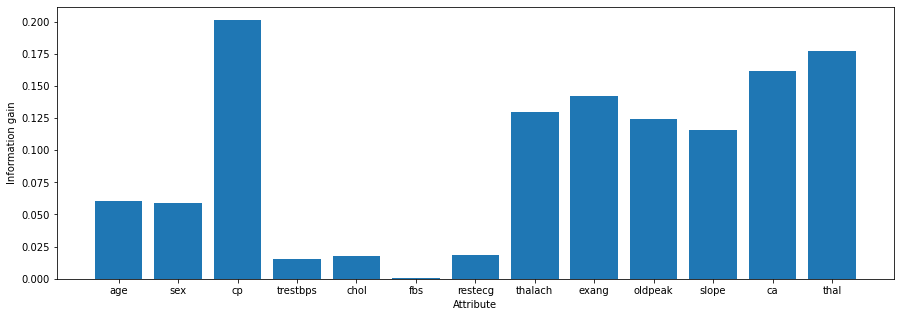

In [ ]:
temp1=[]
temp2=[]

for i in info_gain:
  temp1.append(i)
  temp2.append(info_gain[i])

fig = plt.figure(figsize = (15, 5)) 
plt.ylabel("Information gain")
plt.xlabel("Attribute")
plt.bar(temp1,temp2)
plt.show()

As we can see the information gain of attribute **fbs,trestbps,chol,restecg** is very close to 0 . So, we can remove these feature.

In [ ]:
df=df.drop(['fbs', 'trestbps','chol'], axis=1)
df

,age,sex,cp,restecg,thalach,exang,oldpeak,slope,ca,thal,presence
0,63,1,3,0,150,0,2.3,0,0,1,1
1,37,1,2,1,187,0,3.5,0,0,2,1
2,41,0,1,0,172,0,1.4,2,0,2,1
3,56,1,1,1,178,0,0.8,2,0,2,1
4,57,0,0,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,1,123,1,0.2,1,0,3,0
299,45,1,3,1,132,0,1.2,1,0,3,0
300,68,1,0,1,141,0,3.4,1,2,3,0
301,57,1,0,1,115,1,1.2,1,1,3,0


**Outlier detection and removal using DBSCAN**

In [ ]:
def DBSCAN(d,eps,minpts):
  cluster=[]
  uncluster=[]
  visited={}
  for i in d:
    visited[i]=-1
  
  for sp in d:
    if(visited[sp]==-1):
      visited[sp]=1
      count=0

      neighbor=[]
      for i in range(len(d)):
        if d[i]!=sp:
          dist=np.sqrt(np.sum(np.square(np.array(d[i]) - np.array(sp))))
          if(dist<=eps):
            neighbor.append(d[i])
            count+=1
      if(count<minpts):
        uncluster.append(sp)
      else:
        cluster.append(sp)
        for i in neighbor:
          if visited[i]==-1:
            visited[i]=1
            neighbor_=[]
            count_=0
            for j in range(len(d)):
              if d[j]!=i:
                dist=np.sqrt(np.sum(np.square(np.array(d[j]) - np.array(i))))
                if(dist<=eps):
                  neighbor_.append(d[j])
                  count_+=1
            if(count_>=minpts):
              neighbor=neighbor+neighbor_
          if((i not in cluster) and (i not in uncluster)):
            cluster.append(i)

  return cluster,uncluster  
          

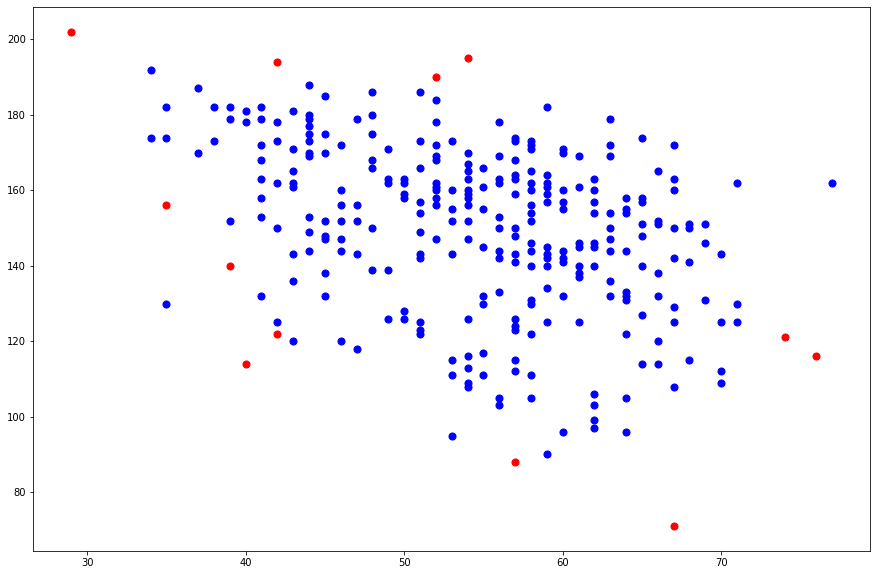

In [ ]:
points=[]
for i in range(len(data)):
  a=data_attr[attribute['age']][i]
  b=data_attr[attribute['thalach']][i]
  points.append((a,b))
  
C,UC=DBSCAN(points,8,5)

fig = plt.figure(figsize = (15, 10))
x=[]
y=[]
for i in C:
  x.append(i[0])
  y.append(i[1])

plt.scatter(x,y, color="blue",marker="o", s=50)
x=[]
y=[]
for i in UC:
  x.append(i[0])
  y.append(i[1])
plt.scatter(x,y, color="red",marker="o", s=50)
plt.show()

In [ ]:
index=[]
for i in range(len(data)):
  f=0
  for j in UC:
    if(data[i][attribute['age']]==j[0] and data[i][attribute['thalach']]==j[1]):
      f=1
  if(f==1):
    index.append(i)

index

[62, 72, 84, 103, 129, 144, 175, 212, 239, 243, 248, 272]

In [ ]:
df.drop(index, inplace = True) 
 

In [ ]:
df

,age,sex,cp,restecg,thalach,exang,oldpeak,slope,ca,thal,presence
0,63,1,3,0,150,0,2.3,0,0,1,1
1,37,1,2,1,187,0,3.5,0,0,2,1
2,41,0,1,0,172,0,1.4,2,0,2,1
3,56,1,1,1,178,0,0.8,2,0,2,1
4,57,0,0,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,1,123,1,0.2,1,0,3,0
299,45,1,3,1,132,0,1.2,1,0,3,0
300,68,1,0,1,141,0,3.4,1,2,3,0
301,57,1,0,1,115,1,1.2,1,1,3,0


In [ ]:
data=np.array(df)
d1=data[:,:-1]
d2=data[:,-1]

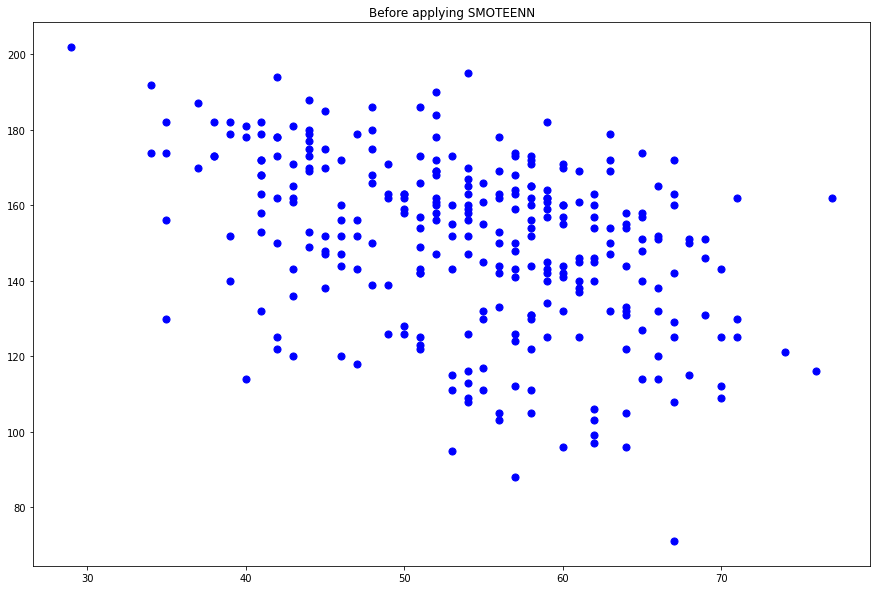

In [ ]:
x=[]
y=[]
for i in range(len(d1)):
  x.append(data_attr[attribute['age']][i])
  y.append(data_attr[attribute['thalach']][i])
fig = plt.figure(figsize = (15, 10))
plt.title("Before applying SMOTEENN")
plt.scatter(x,y, color="blue",marker="o", s=50)
plt.show()

In [ ]:
data=np.array(df)
d1=data[:,:-1]
d2=data[:,-1]

# oversampling the train dataset using SMOTE + ENN
smenn = SMOTEENN()
d1, d2 = smenn.fit_resample(d1, d2)

#split dataset to train and test
test_size = 0.30
X_train, X_test, y_train, y_test = train_test_split(d1, d2, test_size=test_size, shuffle=True)

# fit model no training data
model =XGBClassifier(
 learning_rate =0.002447146072603612,
 n_estimators=5000,
 max_depth=1,
 min_child_weight=1,
 gamma=0.0024674117613464074,
 subsample=1.0,
 colsample_bytree=1e-06,
 objective= 'binary:logistic',
  reg_alpha=0.015474296722426327,
  reg_lambda=1
 )
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test, predictions)
print(confusion_matrix(y_test, predictions))
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("F1 Score: {}".format(f1_score(y_test,predictions)))
print("Recall score: {}".format(recall_score(y_test,predictions)))
print("Precision score: {}".format(precision_score(y_test,predictions)))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

[[21  0]
 [ 0 19]]
Accuracy: 100.00%
F1 Score: 1.0
Recall score: 1.0
Precision score: 1.0


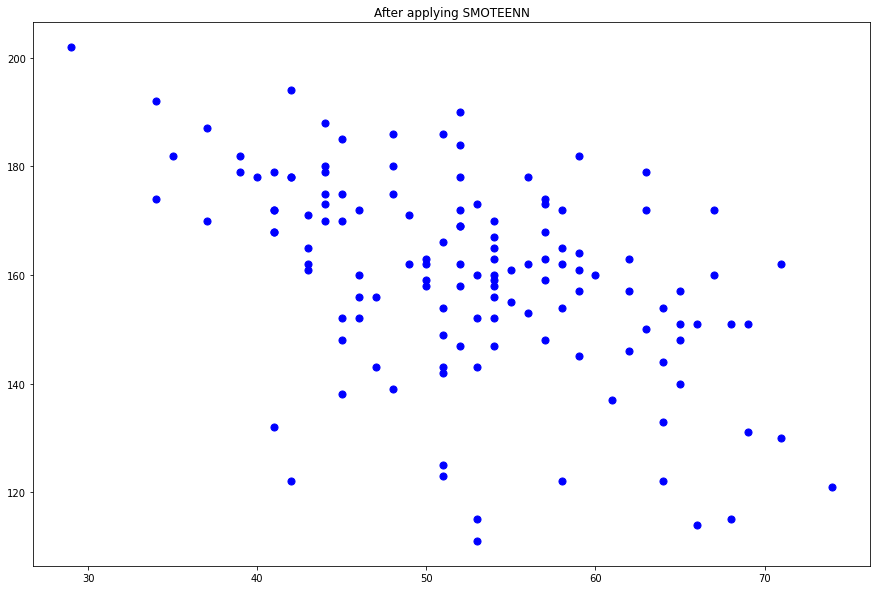

In [ ]:
fig = plt.figure(figsize = (15, 10))
x=[]
y=[]
for i in range(len(d1)):
  x.append(data_attr[attribute['age']][i])
  y.append(data_attr[attribute['thalach']][i])

plt.title("After applying SMOTEENN")
plt.scatter(x,y, color="blue",marker="o", s=50)
plt.show()

In [ ]:
!pip3 install scikit-optimize

     |████████████████████████████████| 102kB 6.0MB/s 


**Parameter tuning using GA**

In [ ]:
# manually tune svm model hyperparameters using skopt on the ionosphere dataset
from numpy import mean
from pandas import read_csv
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from xgboost import XGBClassifier
from skopt.space import Integer
from skopt.space import Real
from skopt.space import Categorical
from skopt.utils import use_named_args
from skopt import gp_minimize

# define the space of hyperparameters to search
search_space = list()
search_space.append(Real(1e-6, 1.0, 'log-uniform', name='learning_rate'))
search_space.append(Integer(1, 5000, name='n_estimators'))
search_space.append(Integer(1, 100, name='max_depth'))
search_space.append(Integer(1, 100, name='min_child_weight'))
search_space.append(Real(1e-6, 100.0, 'log-uniform', name='gamma'))
search_space.append(Real(1e-6, 1.0, 'log-uniform', name='subsample'))
search_space.append(Real(1e-6, 1.0, 'log-uniform', name='colsample_bytree'))
search_space.append(Categorical(['binary:logistic'], name='objective'))
search_space.append(Categorical(['auc','rmse'], name='eval_metric'))
search_space.append(Real(1e-6, 1.0, 'log-uniform', name='reg_alpha'))
search_space.append(Real(1e-6, 1.0, 'log-uniform', name='reg_lambda'))



# define the function used to evaluate a given configuration
@use_named_args(search_space)
def evaluate_model(**params):
	# configure the model with specific hyperparameters
	model = XGBClassifier()
	model.set_params(**params)
	# define test harness
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	# calculate 5-fold cross validation
	result = cross_val_score(model, X, y, cv=cv, n_jobs=-1, scoring='accuracy')
	# calculate the mean of the scores
	estimate = mean(result)
	# convert from a maximizing score to a minimizing score
	return 1.0 - estimate


print(X.shape, y.shape)
# perform optimization
result = gp_minimize(evaluate_model, search_space)
# summarizing finding:
print('Best Accuracy: %.3f' % (1.0 - result.fun))
print('Best Parameters: %s' % (result.x))

(184, 10) (184,)
Best Accuracy: 0.864
Best Parameters: [0.002447146072603612, 5000, 1, 1, 0.0024674117613464074, 1.0, 1e-06, 'binary:logistic', 'auc', 0.015474296722426327, 1.0]


**1.Naive Bayes**

In [ ]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()

data=np.array(df)
d1=data[:,:-1]
d2=data[:,-1]

#split dataset to train and test
test_size = 0.30
X_train, X_test, y_train, y_test = train_test_split(d1, d2, test_size=test_size, shuffle=True)

gnb.fit(X_train, y_train)
y_pred = gnb.predict(X_test)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test, predictions)
M=confusion_matrix(y_test, predictions)
print(confusion_matrix(y_test, predictions))
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("F1 Score: {}".format(f1_score(y_test,predictions)))
print("Recall score: {}".format(recall_score(y_test,predictions)))
print("Precision score: {}".format(precision_score(y_test,predictions)))
print("MCC:",matthews_corrcoef(y_test,predictions))
print("TPR(sensitivity):",M[0][0]/(M[0][0]+M[1][0]))
print("TNR(specificity):",M[1][1]/(M[1][1]+M[0][1]))
print("FPR:",M[1][0]/(M[0][0]+M[1][0]))
print("FNR:",M[0][1]/(M[1][1]+M[0][1]))

[[30 12]
 [11 35]]
Accuracy: 73.86%
F1 Score: 0.7526881720430109
Recall score: 0.7608695652173914
Precision score: 0.7446808510638298
MCC: 0.475771324464925
TPR(sensitivity): 0.7317073170731707
TNR(specificity): 0.7446808510638298
FPR: 0.2682926829268293
FNR: 0.2553191489361702


**2.Linear Regression**

In [ ]:
from sklearn import linear_model
reg = linear_model.LinearRegression()

data=np.array(df)
d1=data[:,:-1]
d2=data[:,-1]

#split dataset to train and test
test_size = 0.30
X_train, X_test, y_train, y_test = train_test_split(d1, d2, test_size=test_size, shuffle=True)

reg.fit(X_train, y_train)
y_pred = gnb.predict(X_test)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test, predictions)
M=confusion_matrix(y_test, predictions)
print(confusion_matrix(y_test, predictions))
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("F1 Score: {}".format(f1_score(y_test,predictions)))
print("Recall score: {}".format(recall_score(y_test,predictions)))
print("Precision score: {}".format(precision_score(y_test,predictions)))
print("MCC:",matthews_corrcoef(y_test,predictions))
print("TPR(sensitivity):",M[0][0]/(M[0][0]+M[1][0]))
print("TNR(specificity):",M[1][1]/(M[1][1]+M[0][1]))
print("FPR:",M[1][0]/(M[0][0]+M[1][0]))
print("FNR:",M[0][1]/(M[1][1]+M[0][1]))

[[27  9]
 [ 5 47]]
Accuracy: 84.09%
F1 Score: 0.8703703703703703
Recall score: 0.9038461538461539
Precision score: 0.8392857142857143
MCC: 0.6682815834102229
TPR(sensitivity): 0.84375
TNR(specificity): 0.8392857142857143
FPR: 0.15625
FNR: 0.16071428571428573


**3.Multi Layer perceptron (MLP)**

In [ ]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(random_state=1, max_iter=300)

data=np.array(df)
d1=data[:,:-1]
d2=data[:,-1]

#split dataset to train and test
test_size = 0.30
X_train, X_test, y_train, y_test = train_test_split(d1, d2, test_size=test_size, shuffle=True)

mlp.fit(X_train, y_train)
y_pred = mlp.predict(X_test)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test, predictions)
print(confusion_matrix(y_test, predictions))
M=confusion_matrix(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("F1 Score: {}".format(f1_score(y_test,predictions)))
print("Recall score: {}".format(recall_score(y_test,predictions)))
print("Precision score: {}".format(precision_score(y_test,predictions)))
print("MCC:",matthews_corrcoef(y_test,predictions))
print("TPR(sensitivity):",M[0][0]/(M[0][0]+M[1][0]))
print("TNR(specificity):",M[1][1]/(M[1][1]+M[0][1]))
print("FPR:",M[1][0]/(M[0][0]+M[1][0]))
print("FNR:",M[0][1]/(M[1][1]+M[0][1]))


[[42  0]
 [35 11]]
Accuracy: 60.23%
F1 Score: 0.3859649122807018
Recall score: 0.2391304347826087
Precision score: 1.0
MCC: 0.3611575592573076
TPR(sensitivity): 0.5454545454545454
TNR(specificity): 1.0
FPR: 0.45454545454545453
FNR: 0.0


**4.Support Vector Machine**

In [ ]:
from sklearn.svm import SVC  
svm = SVC(kernel='linear') 

data=np.array(df)
d1=data[:,:-1]
d2=data[:,-1]

#split dataset to train and test
test_size = 0.30
X_train, X_test, y_train, y_test = train_test_split(d1, d2, test_size=test_size, shuffle=True)

svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test, predictions)
M=confusion_matrix(y_test, predictions)
print(confusion_matrix(y_test, predictions))
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("F1 Score: {}".format(f1_score(y_test,predictions)))
print("Recall score: {}".format(recall_score(y_test,predictions)))
print("Precision score: {}".format(precision_score(y_test,predictions)))
print("MCC:",matthews_corrcoef(y_test,predictions))
print("TPR(sensitivity):",M[0][0]/(M[0][0]+M[1][0]))
print("TNR(specificity):",M[1][1]/(M[1][1]+M[0][1]))
print("FPR:",M[1][0]/(M[0][0]+M[1][0]))
print("FNR:",M[0][1]/(M[1][1]+M[0][1]))

[[30 11]
 [ 2 45]]
Accuracy: 85.23%
F1 Score: 0.8737864077669905
Recall score: 0.9574468085106383
Precision score: 0.8035714285714286
MCC: 0.714641471195373
TPR(sensitivity): 0.9375
TNR(specificity): 0.8035714285714286
FPR: 0.0625
FNR: 0.19642857142857142


**5.Decision Tree**

In [ ]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=0)

data=np.array(df)
d1=data[:,:-1]
d2=data[:,-1]

#split dataset to train and test
test_size = 0.30
X_train, X_test, y_train, y_test = train_test_split(d1, d2, test_size=test_size, shuffle=True)

dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test, predictions)
M=confusion_matrix(y_test, predictions)
print(confusion_matrix(y_test, predictions))
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("F1 Score: {}".format(f1_score(y_test,predictions)))
print("Recall score: {}".format(recall_score(y_test,predictions)))
print("Precision score: {}".format(precision_score(y_test,predictions)))
print("MCC:",matthews_corrcoef(y_test,predictions))
print("TPR(sensitivity):",M[0][0]/(M[0][0]+M[1][0]))
print("TNR(specificity):",M[1][1]/(M[1][1]+M[0][1]))
print("FPR:",M[1][0]/(M[0][0]+M[1][0]))
print("FNR:",M[0][1]/(M[1][1]+M[0][1]))

[[33 10]
 [12 33]]
Accuracy: 75.00%
F1 Score: 0.7499999999999999
Recall score: 0.7333333333333333
Precision score: 0.7674418604651163
MCC: 0.5007751937984496
TPR(sensitivity): 0.7333333333333333
TNR(specificity): 0.7674418604651163
FPR: 0.26666666666666666
FNR: 0.23255813953488372


**6.Random Forest**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(max_depth=2, random_state=0)

data=np.array(df)
d1=data[:,:-1]
d2=data[:,-1]

#split dataset to train and test
test_size = 0.30
X_train, X_test, y_train, y_test = train_test_split(d1, d2, test_size=test_size, shuffle=True)

rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test, predictions)
M=confusion_matrix(y_test, predictions)
print(confusion_matrix(y_test, predictions))
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("F1 Score: {}".format(f1_score(y_test,predictions)))
print("Recall score: {}".format(recall_score(y_test,predictions)))
print("Precision score: {}".format(precision_score(y_test,predictions)))
print("MCC:",matthews_corrcoef(y_test,predictions))
print("TPR(sensitivity):",M[0][0]/(M[0][0]+M[1][0]))
print("TNR(specificity):",M[1][1]/(M[1][1]+M[0][1]))
print("FPR:",M[1][0]/(M[0][0]+M[1][0]))
print("FNR:",M[0][1]/(M[1][1]+M[0][1]))

[[25 11]
 [ 6 46]]
Accuracy: 80.68%
F1 Score: 0.8440366972477065
Recall score: 0.8846153846153846
Precision score: 0.8070175438596491
MCC: 0.5960162288466547
TPR(sensitivity): 0.8064516129032258
TNR(specificity): 0.8070175438596491
FPR: 0.1935483870967742
FNR: 0.19298245614035087


**7.Logistic Regression**

In [ ]:
from sklearn.linear_model import LogisticRegression
Lr = LogisticRegression(random_state=0)

data=np.array(df)
d1=data[:,:-1]
d2=data[:,-1]

#split dataset to train and test
test_size = 0.30
X_train, X_test, y_train, y_test = train_test_split(d1, d2, test_size=test_size, shuffle=True)

Lr.fit(X_train, y_train)
y_pred =Lr.predict(X_test)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test, predictions)
M=confusion_matrix(y_test, predictions)
print(confusion_matrix(y_test, predictions))
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("F1 Score: {}".format(f1_score(y_test,predictions)))
print("Recall score: {}".format(recall_score(y_test,predictions)))
print("Precision score: {}".format(precision_score(y_test,predictions)))
print("MCC:",matthews_corrcoef(y_test,predictions))
print("TPR(sensitivity):",M[0][0]/(M[0][0]+M[1][0]))
print("TNR(specificity):",M[1][1]/(M[1][1]+M[0][1]))
print("FPR:",M[1][0]/(M[0][0]+M[1][0]))
print("FNR:",M[0][1]/(M[1][1]+M[0][1]))

[[25  8]
 [ 4 51]]
Accuracy: 86.36%
F1 Score: 0.8947368421052632
Recall score: 0.9272727272727272
Precision score: 0.864406779661017
MCC: 0.7053550973548743
TPR(sensitivity): 0.8620689655172413
TNR(specificity): 0.864406779661017
FPR: 0.13793103448275862
FNR: 0.13559322033898305


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


**8.K Nearest Neighbors**

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=3)

data=np.array(df)
d1=data[:,:-1]
d2=data[:,-1]

#split dataset to train and test
test_size = 0.30
X_train, X_test, y_train, y_test = train_test_split(d1, d2, test_size=test_size, shuffle=True)

neigh.fit(X_train, y_train)
y_pred =neigh.predict(X_test)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test, predictions)
M=confusion_matrix(y_test, predictions)
print(confusion_matrix(y_test, predictions))
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("F1 Score: {}".format(f1_score(y_test,predictions)))
print("Recall score: {}".format(recall_score(y_test,predictions)))
print("Precision score: {}".format(precision_score(y_test,predictions)))
print("MCC:",matthews_corrcoef(y_test,predictions))
print("TPR(sensitivity):",M[0][0]/(M[0][0]+M[1][0]))
print("TNR(specificity):",M[1][1]/(M[1][1]+M[0][1]))
print("FPR:",M[1][0]/(M[0][0]+M[1][0]))
print("FNR:",M[0][1]/(M[1][1]+M[0][1]))

[[15 26]
 [11 36]]
Accuracy: 57.95%
F1 Score: 0.6605504587155964
Recall score: 0.7659574468085106
Precision score: 0.5806451612903226
MCC: 0.14411538310044347
TPR(sensitivity): 0.5769230769230769
TNR(specificity): 0.5806451612903226
FPR: 0.4230769230769231
FNR: 0.41935483870967744


**9.K means cluster**

In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, random_state=0)

data=np.array(df)
d1=data[:,:-1]
d2=data[:,-1]

#split dataset to train and test
test_size = 0.30
X_train, X_test, y_train, y_test = train_test_split(d1, d2, test_size=test_size, shuffle=True)

kmeans.fit(X_train, y_train)
y_pred =kmeans.predict(X_test)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test, predictions)
M=confusion_matrix(y_test, predictions)
print(confusion_matrix(y_test, predictions))
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("F1 Score: {}".format(f1_score(y_test,predictions)))
print("Recall score: {}".format(recall_score(y_test,predictions)))
print("Precision score: {}".format(precision_score(y_test,predictions)))
print("MCC:",matthews_corrcoef(y_test,predictions))
print("TPR(sensitivity):",M[0][0]/(M[0][0]+M[1][0]))
print("TNR(specificity):",M[1][1]/(M[1][1]+M[0][1]))
print("FPR:",M[1][0]/(M[0][0]+M[1][0]))
print("FNR:",M[0][1]/(M[1][1]+M[0][1]))

[[13 30]
 [32 13]]
Accuracy: 29.55%
F1 Score: 0.2954545454545454
Recall score: 0.28888888888888886
Precision score: 0.3023255813953488
MCC: -0.40878552971576226
TPR(sensitivity): 0.28888888888888886
TNR(specificity): 0.3023255813953488
FPR: 0.7111111111111111
FNR: 0.6976744186046512


**10.K medoids**

In [ ]:
!pip install scikit-learn-extra
from sklearn_extra.cluster import KMedoids

kmedoids = KMedoids(n_clusters=2, random_state=0)

data=np.array(df)
d1=data[:,:-1]
d2=data[:,-1]

#split dataset to train and test
test_size = 0.30
X_train, X_test, y_train, y_test = train_test_split(d1, d2, test_size=test_size, shuffle=True)

kmedoids.fit(X_train, y_train)
y_pred =kmedoids.predict(X_test)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test, predictions)
M=confusion_matrix(y_test, predictions)
print(confusion_matrix(y_test, predictions))
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("F1 Score: {}".format(f1_score(y_test,predictions)))
print("Recall score: {}".format(recall_score(y_test,predictions)))
print("Precision score: {}".format(precision_score(y_test,predictions)))
print("MCC:",matthews_corrcoef(y_test,predictions))
print("TPR(sensitivity):",M[0][0]/(M[0][0]+M[1][0]))
print("TNR(specificity):",M[1][1]/(M[1][1]+M[0][1]))
print("FPR:",M[1][0]/(M[0][0]+M[1][0]))
print("FNR:",M[0][1]/(M[1][1]+M[0][1]))

     |████████████████████████████████| 624kB 9.1MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for scikit-learn-extra: filename=scikit_learn_extra-0.1.0b2-cp37-cp37m-linux_x86_64.whl size=339934 sha256=e9eadb7e2cb6ef3d978a422a0c3a39ad615407dcfe60f5c562f24aa6a72d1894
  Stored in directory: /root/.cache/pip/wheels/04/01/0f/943bffb48bac048fa216b4325f1a6c939491ccb0ff500e08f4
Successfully built scikit-learn-extra
[[22 19]
 [13 34]]
Accuracy: 63.64%
F1 Score: 0.68
Recall score: 0.723404255319149
Precision score: 0.6415094339622641
MCC: 0.2649872093821886
TPR(sensitivity): 0.6285714285714286
TNR(specificity): 0.6415094339622641
FPR: 0.37142857142857144
FNR: 0.3584905660377358


In [ ]:
itr=100
Acc=0
F1=0
Recall=0
Prec=0
MCC=0
TPR=0
TNR=0
FPR=0
FNR=0


for i in range(itr):
  
  from sklearn_extra.cluster import KMedoids

  kmedoids = KMedoids(n_clusters=2, random_state=0)

  data=np.array(df)
  d1=data[:,:-1]
  d2=data[:,-1]

  #split dataset to train and test
  test_size = 0.30
  X_train, X_test, y_train, y_test = train_test_split(d1, d2, test_size=test_size, shuffle=True)

  kmedoids.fit(X_train, y_train)
  y_pred =kmedoids.predict(X_test)
  predictions = [round(value) for value in y_pred]
  accuracy = accuracy_score(y_test, predictions)


  M=confusion_matrix(y_test, predictions)
  # print(confusion_matrix(y_test, predictions))
  Acc=Acc + accuracy * 100.0
  F1=F1+ f1_score(y_test,predictions)
  Recall= Recall + recall_score(y_test,predictions)
  Prec =Prec + precision_score(y_test,predictions)
  MCC=MCC+matthews_corrcoef(y_test,predictions)
  TPR=TPR+ (M[0][0]/(M[0][0]+M[1][0]))
  TNR=TNR+ (M[1][1]/(M[1][1]+M[0][1]))
  FPR=FPR+ (M[1][0]/(M[0][0]+M[1][0]))
  FNR=FNR+ (M[0][1]/(M[1][1]+M[0][1]))

print("Accuracy: %.2f%%" % (Acc/itr))
print("F1 Score: {}".format(F1/itr))
print("Recall score: {}".format(Recall/itr))
print("Precision score: {}".format(Prec/itr))
print("MCC:",MCC/itr)
print("TPR(sensitivity):",TPR/itr)
print("TNR(specificity):",TNR/itr)
print("FPR:",FPR/itr)
print("FNR:",FNR/itr)

Accuracy: 52.03%
F1 Score: 0.524308648866512
Recall score: 0.5250831327437738
Precision score: 0.5333046179613039
MCC: 0.04186987371386431
TPR(sensitivity): 0.5080647280422778
TNR(specificity): 0.5333046179613039
FPR: 0.49193527195772224
FNR: 0.466695382038696


In [ ]:
model =XGBClassifier(
 learning_rate =0.002447146072603612,
 n_estimators=5000,
 max_depth=1,
 min_child_weight=1,
 gamma=0.0024674117613464074,
 subsample=1.0,
 colsample_bytree=1e-06,
 objective= 'binary:logistic',
  reg_alpha=0.015474296722426327,
  reg_lambda=1
 )
model

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1e-06,
              gamma=0.0024674117613464074, learning_rate=0.002447146072603612,
              max_delta_step=0, max_depth=1, min_child_weight=1, missing=None,
              n_estimators=5000, n_jobs=1, nthread=None,
              objective='binary:logistic', random_state=0,
              reg_alpha=0.015474296722426327, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=None, subsample=1.0, verbosity=1)